In [1]:
import os

input_dir = 'images'
target_dir = 'annotations/trimaps'
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted([os.path.join(input_dir, fname) 
                          for fname in os.listdir(input_dir)
                             if fname.endswith('.jpg')])
target_img_paths = sorted([os.path.join(target_dir, fname) 
                          for fname in os.listdir(target_dir)
                             if fname.endswith('.png') and not fname.startswith('.')])

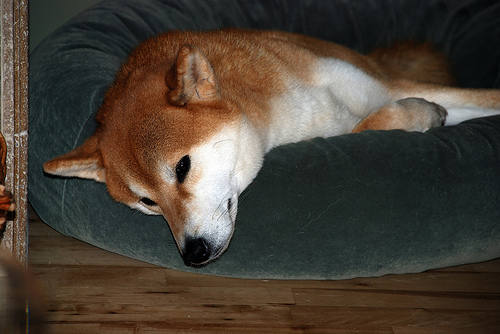

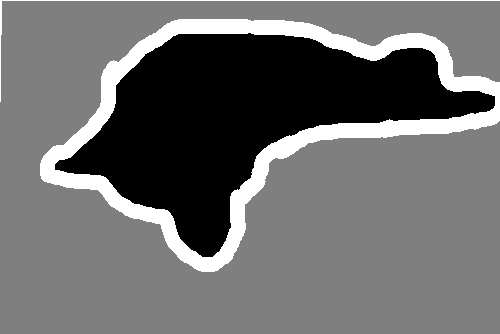

In [259]:
from IPython.display import Image, display
import PIL
from PIL import ImageOps
import PIL.Image as pilimg

imgno = 22

display(Image(filename=input_img_paths[imgno]))
img = PIL.ImageOps.autocontrast(pilimg.open(target_img_paths[imgno]))

display(img)

# Data Preprocessing

In [250]:
import numpy as np
#from tensorflow import keras
import torch
import torch.nn as nn

In [ ]:
class Dataset(torch.utils.data.Dataset): 
     # torch.utils.data.Dataset 이라는 파이토치 base class를 상속받아 
     # 그 method인 __len__(), __getitem__()을 오버라이딩 해줘서 
     # 사용자 정의 Dataset class를 선언한다
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    # 여기가 데이터 load하는 파트
    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        inputs = np.load(os.path.join(self.data_dir, self.lst_input[index]))

# normalize, 이미지는 0~255 값을 가지고 있어 이를 0~1사이로 scaling
        label = label/255.0
        inputs = inputs/255.0
        label = label.astype(np.float32)
        inputs = inputs.astype(np.float32)
        
# 인풋 데이터 차원이 2이면, 채널 축을 추가해줘야한다. 
# 파이토치 인풋은 (batch, 채널, 행, 열)

        if label.ndim == 2:  
            label = label[:,:,np.newaxis]
        if inputs.ndim == 2:  
            inputs = inputs[:,:,np.newaxis] 

        data = {'input':inputs, 'label':label}

        if self.transform:
            data = self.transform(data)
# transform에 할당된 class 들이 호출되면서 __call__ 함수 실행

        return data

In [270]:
class OxfordPets(torch.utils.data.Dataset):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
    
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i+self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3, ), dtype = 'float32')
        for j, path in enumerate(batch_input_img_paths):
            img = np.load(path, target_size = self.img_size)
            x[j] = img
            
        y = np.zeros((self.batch_size,) + self.img_size + (1, ), dtype = 'uint8') # color가 아니라 grayscale이므로 1
        for j, path in enumerate(batch_target_img_paths):
            img = np.load(path, target_size = self.img_size, color_mode = 'grayscale')
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1 # label이 123 으로 되어있는데 이걸 012 로 맞춰주기 위함\

        return x, y

In [272]:
import random

val_samples = 1000
random.Random(88).shuffle(input_img_paths)
random.Random(88).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [77]:
# Not work
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, out_channels*depth, kernel_size=kernel_size, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(out_channels*depth, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [242]:
# padding='same' is equal to (kernel_size-1)/2

class Unet(nn.Module): for batch, data in enumerate(loader_train,1): # 1은 뭐니 > index start point
        # forward
        
        label = data['label'].to(device)   # 데이터 device로 올리기     
        inputs = data['input'].to(device)
    def __init__(self, num_classes):
        super(Unet, self).__init__()
        
        #inputs =  torch.randn((1, 3,) + img_size) # Batch size, Channel, H, W. # Keras.input = HxWxC
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            return cbr
            
            
        self.enc0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        def CBR2d_dec(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            layers = []
            layers += [nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                          kernel_size=kernel_size, stride=stride, padding=padding)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            return cbr
    
        self.enc1_1 = CBR2d(in_channels = 32, out_channels=64)
        self.enc1_2 = CBR2d(in_channels = 64, out_channels=64)
        self.pool1 =  nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.enc1_residual = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=2, padding=0) #Previous acitvation block

        self.enc2_1 = CBR2d(in_channels = 64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels = 128, out_channels=128)
        self.pool2 =  nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.enc2_residual = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2, padding=0) #Previous acitvation block

        self.enc3_1 = CBR2d(in_channels = 128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels = 256, out_channels=256)
        self.pool3 =  nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.enc3_residual = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2, padding=0) #Previous acitvation block

        #----------------------------------------------------------------

        self.upsample = nn.Upsample(scale_factor=2)
        
        self.dec1_1 = CBR2d_dec(in_channels = 256, out_channels=256)
        self.dec1_2 = CBR2d_dec(in_channels = 256, out_channels=256)
        self.dec1_residual = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding=1)
        
        self.dec2_1 = CBR2d_dec(in_channels = 256, out_channels=128)
        self.dec2_2 = CBR2d_dec(in_channels = 128, out_channels=128)
        self.dec2_residual = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, padding=1)
        
        self.dec3_1 = CBR2d_dec(in_channels = 128, out_channels=64)
        self.dec3_2 = CBR2d_dec(in_channels = 64, out_channels=64)
        self.dec3_residual = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, padding=1)
        
        self.dec4_1 = CBR2d_dec(in_channels =64, out_channels=32)
        self.dec4_2 = CBR2d_dec(in_channels =32, out_channels=32)
        self.dec4_residual = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, padding=1)
        
        self.fc_layer = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=3, padding=1),
            nn.Softmax()
        )
        
        
    def forward(self, x):
        x = self.enc0(x)
        previous_block_activation = x # residual
        
        out = self.enc1_1(x)
        out = self.enc1_2(out)
        out = self.pool1(out)
        residual = self.enc1_residual(previous_block_activation)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        out = self.enc2_1(x)
        out = self.enc2_2(out)
        out = self.pool2(out)
        residual = self.enc2_residual(previous_block_activation)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        out = self.enc3_1(x)
        out = self.enc3_2(out)
        out = self.pool3(out)
        residual = self.enc3_residual(previous_block_activation)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        out = self.dec1_1(out)
        out = self.dec1_2(out)
        out = self.upsample(out)
        residual = self.upsample(previous_block_activation)
        residual = self.dec1_residual(residual)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        out = self.dec2_1(out)
        out = self.dec2_2(out)
        out = self.upsample(out)
        residual = self.upsample(previous_block_activation)
        residual = self.dec2_residual(residual)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        out = self.dec3_1(out)
        out = self.dec3_2(out)
        out = self.upsample(out)
        residual = self.upsample(previous_block_activation)
        residual = self.dec3_residual(residual)
        out = torch.add(out, residual)
        previous_block_activation = out
             
        out = self.dec4_1(out)
        out = self.dec4_2(out)
        out = self.upsample(out)
        residual = self.upsample(previous_block_activation)
        residual = self.dec4_residual(residual)
        out = torch.add(out, residual)
        previous_block_activation = out
        
        outputs = self.fc_layer(out)
        return outputs 

In [252]:
import torch.optim as optim
from torch.optim import lr_scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(77)
if device == 'cuda':
    torch.cuda.manual_seed_all(77)
print(f"uning: {device}")

 
model = Unet(num_classes).to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

uning: cuda


In [273]:
# 네트워크 저장하기
# train을 마친 네트워크 저장 
# net : 네트워크 파라미터, optim  두개를 dict 형태로 저장
def save(ckpt_dir,net,optim,epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

# 네트워크 불러오기
def load(ckpt_dir,net,optim):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str,isdigit,f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net,optim,epoch

# Training

In [282]:
loader_train = DataLoader(train_gen, batch_size=batch_size)
loader_val = DataLoader(val_gen, batch_size=batch_size)

train_features, train_labels = next(iter(loader_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


TypeError: load() got an unexpected keyword argument 'target_size'

In [275]:
from torch.utils.data import DataLoader
loader_train = DataLoader(train_gen, batch_size=batch_size)
loader_val = DataLoader(val_gen, batch_size=batch_size)

batch_size = batch_size
learning_rate = 1e-3
num_epoch = 20

optim = torch.optim.Adam(net.parameters(), lr = lr ) 


for epoch in range(start_epoch+1,num_epoch +1):
    loss_arr = []

    for batch, data in enumerate(loader_train,1): # 1은 뭐니 > index start point
        # forward
        
        label = data['label'].to(device)   # 데이터 device로 올리기     
        inputs = data['input'].to(device)
        output = model(inputs) 

        # backward
        optim.zero_grad()  # gradient 초기화
        loss = fn_loss(output, label)  # output과 label 사이의 loss 계산
        loss.backward() # gradient backpropagation
        optim.step() # backpropa 된 gradient를 이용해서 각 layer의 parameters update

        # save loss
        loss_arr += [loss.item()]

        # tensorbord에 결과값들 저정하기
        label = fn_tonumpy(label)
        inputs = fn_tonumpy(fn_denorm(inputs,0.5,0.5))
        output = fn_tonumpy(fn_classifier(output))

        writer_train.add_image('label', label, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('input', inputs, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)
    
    # validation
    with torch.no_grad(): # validation 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
        net.eval() # 네트워크를 evaluation 용으로 선언
        loss_arr = []

        for batch, data in enumerate(loader_val,1):
            # forward
            label = data['label'].to(device)
            inputs = data['input'].to(device)
            output = net(inputs)

            # loss 
            loss = fn_loss(output,label)
            loss_arr += [loss.item()]
            print('valid : epoch %04d / %04d | Batch %04d \ %04d | Loss %04d'%(epoch,num_epoch,batch,num_val_for_epoch,np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            inputs = fn_tonumpy(fn_denorm(inputs, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_classifier(output))

            writer_val.add_image('label', label, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('input', inputs, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch이 끝날때 마다 네트워크 저장
        save(ckpt_dir=ckpt_dir, net = net, optim = optim, epoch = epoch)

writer_train.close()
writer_val.close()

NameError: name 'net' is not defined

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=img_size + (3,))
inputs

<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_6')>

In [216]:
inputs =  torch.randn((1, 3,) + img_size) # Batch size, Channel, H, W. # Keras.input = HxWxC

x = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)(inputs)
x = nn.BatchNorm2d(32)(x)

In [217]:
x.shape

torch.Size([1, 32, 80, 80])

In [67]:
inputs = keras.Input(shape=img_size + (3,))
    
x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)


In [76]:
count = 0

for filters in [64, 128, 256]:
    print(filters)

64
128
256


In [73]:
count

3

In [80]:
input1 = layers.Input(shape=(16,))
x1 = layers.Dense(8, activation='relu')(input1)
input2 = layers.Input(shape=(32,))
x2 = layers.Dense(8, activation='relu')(input2)

# equivalent to `added = tf.keras.layers.add([x1, x2])`

added = layers.add([x1, x2])

In [81]:
added

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'add')>

In [235]:
input = torch.arange(1, 5, dtype=torch.float32).view(1, 1, 2, 2)
input.shape, input

(torch.Size([1, 1, 2, 2]),
 tensor([[[[1., 2.],
           [3., 4.]]]]))

In [237]:
m = torch.cat(input, input, dim=1)

TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, name dim, *, Tensor out)
 * (tuple of Tensors tensors, int dim, *, Tensor out)


In [139]:
m.shape, m

(torch.Size([1, 1, 4, 4]),
 tensor([[[[1., 1., 2., 2.],
           [1., 1., 2., 2.],
           [3., 3., 4., 4.],
           [3., 3., 4., 4.]]]]))

In [136]:
 input_shape = (2, 1, 3, 2)
x = np.arange(np.prod((input_shape))).reshape(input_shape)
x.shape

(2, 1, 3, 2)

In [137]:
y = layers.UpSampling2D(size=2)(x)
y

<tf.Tensor: shape=(2, 2, 6, 2), dtype=int64, numpy=
array([[[[ 0,  1],
         [ 0,  1],
         [ 2,  3],
         [ 2,  3],
         [ 4,  5],
         [ 4,  5]],

        [[ 0,  1],
         [ 0,  1],
         [ 2,  3],
         [ 2,  3],
         [ 4,  5],
         [ 4,  5]]],


       [[[ 6,  7],
         [ 6,  7],
         [ 8,  9],
         [ 8,  9],
         [10, 11],
         [10, 11]],

        [[ 6,  7],
         [ 6,  7],
         [ 8,  9],
         [ 8,  9],
         [10, 11],
         [10, 11]]]])>

In [142]:
for filters, i in enumerate([256, 128, 64, 32]):
    print(filters, i)

0 256
1 128
2 64
3 32


In [204]:
def compressWord(word, k):
    dic = {}
    before = str("0"+word)
    result = ""
    
    for i, w in enumerate(word):
        if not w in dic:
            dic[w]=1
        else:
            if before[i] == w:
                dic[w] +=1
            
    for w in word:
        if dic[w] != k:
            result = result+w

    if result == word:
        return [result]
    else:
        return compressWord(result, k)



In [205]:
re = compressWord("acdddcca", 3)
re

['aa']